In [1]:
import numpy as np

In [2]:
topic = {}
tfidf = dict(list(zip('cat dog apple lion NYC love'.split(), np.random.rand(6))))
topic['pet'] = (.3 * tfidf['cat'] + .3 * tfidf['dog'] + 0 * tfidf['apple']
                + 0 * tfidf['lion'] - .2 * tfidf['NYC'] + .2 * tfidf['love'])
topic['animal'] = (.1 * tfidf['cat'] + .1 * tfidf['dog'] - .1 * tfidf['apple']
                   + .5 * tfidf['lion'] + .1 * tfidf['NYC'] - .1 * tfidf['love'])
topic['city'] = (0 * tfidf['cat'] - .1 * tfidf['dog'] + .2 * tfidf['apple']
                 - .1 * tfidf['lion'] + .5 * tfidf['NYC'] + .1 * tfidf['love'])

In [3]:
tfidf

{'cat': 0.09431770234230563,
 'dog': 0.6954853487544275,
 'apple': 0.502480447469573,
 'lion': 0.5576262832241917,
 'NYC': 0.31264859109503074,
 'love': 0.599220110484832}

In [4]:
topic

{'pet': 0.29425521920698017,
 'animal': 0.27888825003583173,
 'city': 0.19143123289205125}

In [5]:
word_vector = {}
word_vector['cat'] = .3 * topic['pet'] + .1 * topic['animal'] + 0 * topic['city']
word_vector['dog'] = .3 * topic['pet'] + .1 * topic['animal'] - .1 * topic['city']
word_vector['apple'] = 0 * topic['pet'] - .1 * topic['animal'] + .2 * topic['city']
word_vector['lion'] = 0 * topic['pet'] + .5 * topic['animal'] - .1 * topic['city']
word_vector['NYC'] = -.2 * topic['pet'] + .1 * topic['animal'] + .5 * topic['city']
word_vector['love'] = .2 * topic['pet'] - .1 * topic['animal'] + .1 * topic['city']
word_vector

{'cat': 0.11616539076567722,
 'dog': 0.0970222674764721,
 'apple': 0.010397421574827079,
 'lion': 0.12030100172871074,
 'NYC': 0.06475339760821276,
 'love': 0.05010534212701799}

### 4.1.5 An LDA classifier

In [6]:
from nlpia.data.loaders import get_data
import pandas as pd

2023-03-21 15:39:03.642529: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/yeabinmoon/opt/anaconda3/envs/tensorflow_env/lib/python3.9/site-packages/pugnlp/constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
/Users/yeabinmoon/opt/anaconda3/envs/tensorflow_env/lib/python3.9/site-packages/pugnlp/constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
/Users/yea

In [7]:
pd.options.display.width = 120

In [8]:
sms = get_data('sms-spam')
index = ['sms{}{}'.format(i, '!'*j) for (i,j) in zip(range(len(sms)), sms.spam)] 
sms = pd.DataFrame(sms.values, columns=sms.columns, index=index)

In [9]:
sms['spam']

sms0        0
sms1        0
sms2!       1
sms3        0
sms4        0
           ..
sms4832!    1
sms4833     0
sms4834     0
sms4835     0
sms4836     0
Name: spam, Length: 4837, dtype: object

In [10]:
sms['spam'] = sms.spam.astype(int)

In [11]:
len(sms)

4837

In [12]:
sms.spam.sum()

638

In [13]:
sms.head(6)

,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."
sms5!,1,FreeMsg Hey there darling it's been 3 week's n...


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

In [15]:
tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)

In [16]:
tfidf_docs = tfidf_model.fit_transform(raw_documents=sms.text).toarray()

/Users/yeabinmoon/opt/anaconda3/envs/tensorflow_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [17]:
tfidf_docs.shape

(4837, 9232)

In [18]:
sms.spam.sum()

638

In [19]:
mask = sms.spam.astype(bool).values

In [20]:
spam_centroid = tfidf_docs[mask].mean(axis=0)

In [21]:
ham_centroid = tfidf_docs[~mask].mean(axis=0)

In [22]:
spam_centroid.round(2)

array([0.06, 0.  , 0.  , ..., 0.  , 0.  , 0.  ])

In [23]:
spam_centroid.shape

(9232,)

In [24]:
ham_centroid.round(2)

array([0.02, 0.01, 0.  , ..., 0.  , 0.  , 0.  ])

In [25]:
ham_centroid.shape

(9232,)

In [26]:
spamminess_score = tfidf_docs.dot(spam_centroid - ham_centroid)

In [27]:
print(spamminess_score.round(2))
print(spamminess_score.shape)

[-0.01 -0.02  0.04 ... -0.01 -0.    0.  ]
(4837,)


In [28]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
tfidf_docs.shape

(4837, 9232)

In [30]:
sms['lda_score'] = MinMaxScaler().fit_transform(spamminess_score.reshape(-1,1))

In [31]:
sms['lda_predict'] = (sms.lda_score > .5).astype(int)

In [32]:
sms

,spam,text,lda_score,lda_predict
sms0,0,"Go until jurong point, crazy.. Available only ...",0.227478,0
sms1,0,Ok lar... Joking wif u oni...,0.177888,0
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...,0.718785,1
sms3,0,U dun say so early hor... U c already then say...,0.184565,0
sms4,0,"Nah I don't think he goes to usf, he lives aro...",0.286944,0
...,...,...,...,...
sms4832!,1,This is the 2nd time we have tried 2 contact u...,0.850649,1
sms4833,0,Will ü b going to esplanade fr home?,0.292753,0
sms4834,0,"Pity, * was in mood for that. So...any other s...",0.269454,0
sms4835,0,The guy did some bitching but I acted like i'd...,0.331306,0


In [33]:
(1. - (sms.spam - sms.lda_predict).abs().sum() / len(sms)).round(3)

0.977

In [34]:
from sklearn.metrics import confusion_matrix

In [35]:
confusion_matrix(sms.spam, sms.lda_predict)

array([[4135,   64],
       [  45,  593]])

### 2-dimensional plot

Text(0, 0.5, ' y')

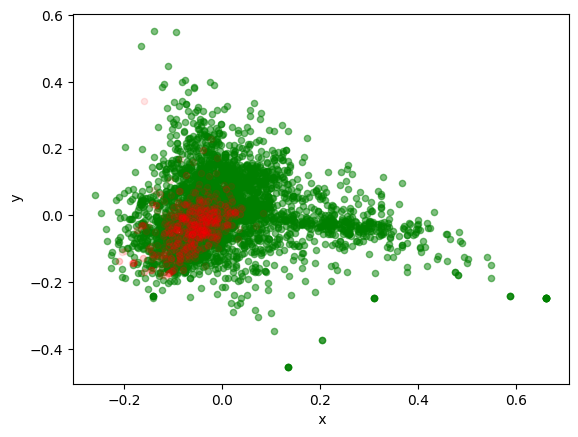

In [36]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn
pca_model = PCA(n_components=3)
tfidf_docs_3d = pca_model.fit_transform(tfidf_docs)
df = pd.DataFrame(tfidf_docs_3d)
ax = df[~mask].plot(x=0, y=1, kind='scatter', alpha=.5, c='green')
df[mask].plot(x=0, y=1, ax=ax, alpha=.1, kind='scatter', c='red')
plt.xlabel(' x')
plt.ylabel(' y')

### 3-dimensional plot

In [37]:
import plotly as py
spam_trace = dict(
        x=df[0][mask], y=df[1][mask], z=df[2][mask],
        type="scatter3d", mode='markers',
        marker= dict(size=3, color='red', line=dict(width=0)) 
    )
ham_trace = dict(
        x=df[0][~mask], y=df[1][~mask], z=df[2][~mask],
        type="scatter3d", mode='markers',
        marker= dict(size=3, color='green', line=dict(width=0)) 
    )
fig = dict(data=[ham_trace, spam_trace], layout={'title': 'LDA Spamminess Model'})
py.offline.plot(fig, filename='lda_spam_3d_scatter.html')

'lda_spam_3d_scatter.html'

## 4.2 Latent semantic analysis

**What' does the following lines do?**

In [38]:
from nlpia.book.examples.ch04_catdog_lsa_3x6x16 import word_topic_vectors
word_topic_vectors.T.round(1)

100%|██████████| 263/263 [00:00<00:00, 121020.51it/s]


,cat,dog,apple,lion,nyc,love
top0,-0.6,-0.4,0.5,-0.3,0.4,-0.1
top1,-0.1,-0.3,-0.4,-0.1,0.1,0.8
top2,-0.3,0.8,-0.1,-0.5,0.0,0.1


## 4.3 Singular value decomposition

In [39]:
from nlpia.book.examples.ch04_catdog_lsa_sorted import lsa_models, prettify_tdm

100%|██████████| 263/263 [00:00<00:00, 144650.14it/s]


In [40]:
bow_svd, tfidf_svd = lsa_models()

100%|██████████| 263/263 [00:00<00:00, 352091.27it/s]


In [41]:
prettify_tdm(**bow_svd)

,cat,dog,apple,lion,nyc,love,text
0,,,1,,1,,NYC is the Big Apple.
1,,,1,,1,,NYC is known as the Big Apple.
2,,,,,1,1,I love NYC!
3,,,1,,1,,I wore a hat to the Big Apple party in NYC.
4,,,1,,1,,Come to NYC. See the Big Apple!
5,,,1,,,,Manhattan is called the Big Apple.
6,1,,,,,,New York is a big city for a small cat.
7,1,,,1,,,"The lion, a big cat, is the king of the jungle."
8,1,,,,,1,I love my pet cat.
9,,,,,1,1,I love New York City (NYC).


When used in function calls, the ** syntax allows you to pass a dictionary of keyword arguments to a function. For example, if a function is defined to take arguments like this: def my_function(a, b, c=0, d=0):, you could call it with a dictionary of keyword arguments like this: my_function(a=1, b=2, **{"c": 3, "d": 4}). This is equivalent to calling my_function(a=1, b=2, c=3, d=4).

In [48]:
tdm = bow_svd['tdm']

In [49]:
tdm

,0,1,2,3,4,5,6,7,8,9,10
cat,0,0,0,0,0,0,1,1,1,0,1
dog,0,0,0,0,0,0,0,0,0,0,1
apple,1,1,0,1,1,1,0,0,0,0,0
lion,0,0,0,0,0,0,0,1,0,0,0
nyc,1,1,1,1,1,0,0,0,0,1,0
love,0,0,1,0,0,0,0,0,1,1,0


In [56]:
tdm.T

,cat,dog,apple,lion,nyc,love
0,0,0,1,0,1,0
1,0,0,1,0,1,0
2,0,0,0,0,1,1
3,0,0,1,0,1,0
4,0,0,1,0,1,0
5,0,0,1,0,0,0
6,1,0,0,0,0,0
7,1,0,0,1,0,0
8,1,0,0,0,0,1
9,0,0,0,0,1,1


In [51]:
X_centered = tdm.T - tdm.T.mean(axis = 0)
U, s, Vt = np.linalg.svd(X_centered)

In [53]:
Vt.round(2)

array([[ 0.59,  0.16, -0.54,  0.16, -0.55,  0.09],
       [-0.16, -0.12, -0.46, -0.12,  0.34,  0.79],
       [ 0.  ,  0.71, -0.  , -0.71,  0.  , -0.  ],
       [ 0.11,  0.41, -0.35,  0.41,  0.64, -0.34],
       [-0.65,  0.45, -0.02,  0.45, -0.39,  0.16],
       [-0.44, -0.3 , -0.61, -0.3 , -0.13, -0.49]])

In [54]:
W2 = Vt[:2].T
X2D = X_centered @W2

In [55]:
X2D

,0,1
0,-0.811442,-0.234370
1,-0.811442,-0.234370
2,-0.186998,1.015455
3,-0.811442,-0.234370
4,-0.811442,-0.234370
5,-0.258597,-0.571190
6,0.868965,-0.267330
7,1.025605,-0.386337
8,0.958188,0.517764
9,-0.186998,1.015455


## 4.4 Principal component analysis

In [57]:
from sklearn.decomposition import PCA


In [61]:
sms = get_data('sms-spam')

In [62]:
index = ['sms{}{}'.format(i, '!'*j) for (i,j) in zip(range(len(sms)), sms.spam)]

In [63]:
sms.index = index
sms.head()

,spam,text
sms0,0,"Go until jurong point, crazy.. Available only in bu..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup final tkt...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives around h..."


In [64]:
tfidf = TfidfVectorizer(tokenizer=casual_tokenize)

In [65]:
tfidf_docs = tfidf.fit_transform(raw_documents=sms.text).toarray()

/Users/yeabinmoon/opt/anaconda3/envs/tensorflow_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [66]:
len(tfidf.vocabulary_)

9232

In [67]:
tfidf.vocabulary_

{'go': 3807,
 'until': 8487,
 'jurong': 4675,
 'point': 6296,
 ',': 13,
 'crazy': 2549,
 '..': 21,
 'available': 1531,
 'only': 5910,
 'in': 4396,
 'bugis': 1973,
 'n': 5594,
 'great': 3894,
 'world': 8977,
 'la': 4811,
 'e': 3056,
 'buffet': 1971,
 '...': 25,
 'cine': 2277,
 'there': 8071,
 'got': 3855,
 'amore': 1296,
 'wat': 8736,
 'ok': 5874,
 'lar': 4848,
 'joking': 4642,
 'wif': 8875,
 'u': 8395,
 'oni': 5906,
 'free': 3604,
 'entry': 3195,
 '2': 471,
 'a': 1054,
 'wkly': 8933,
 'comp': 2386,
 'to': 8192,
 'win': 8890,
 'fa': 3328,
 'cup': 2608,
 'final': 3450,
 'tkts': 8180,
 '21st': 497,
 'may': 5272,
 '2005': 487,
 '.': 15,
 'text': 8020,
 '87121': 948,
 'receive': 6688,
 'question': 6574,
 '(': 9,
 'std': 7651,
 'txt': 8379,
 'rate': 6628,
 ')': 10,
 't': 7889,
 '&': 7,
 "c's": 2020,
 'apply': 1383,
 '08452810075': 115,
 'over': 6003,
 '18': 438,
 "'": 8,
 's': 6959,
 'dun': 3041,
 'say': 7034,
 'so': 7438,
 'early': 3069,
 'hor': 4207,
 'c': 2019,
 'already': 1268,
 'then': 

In [68]:
tfidf_docs = pd.DataFrame(tfidf_docs)


In [70]:
tfidf_docs.head()

,0,1,2,3,4,5,6,7,...,9224,9225,9226,9227,9228,9229,9230,9231
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102819,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
tfidf_docs.shape

(4837, 9232)

In [73]:
sms.spam.sum()

638

In [74]:
pca = PCA(n_components=16)

In [75]:
pca = pca.fit(tfidf_docs)

In [76]:
pca_topic_vectors = pca.transform(tfidf_docs)

In [77]:
columns = ['topic{}'.format(i) for i in range(pca.n_components)]

In [78]:
pca_topic_vectors = pd.DataFrame(pca_topic_vectors, columns=columns, index=index)

In [80]:
pca_topic_vectors.round(3).head(6)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15
sms0,0.201,0.003,0.037,0.011,-0.019,-0.053,0.039,-0.066,0.016,-0.083,0.006,-0.007,-0.007,-0.034,-0.002,0.028
sms1,0.404,-0.094,-0.078,0.051,0.100,0.047,0.023,0.066,0.019,-0.025,-0.004,0.042,0.040,-0.022,0.045,-0.037
sms2!,-0.030,-0.048,0.090,-0.067,0.091,-0.043,-0.000,-0.005,-0.052,0.051,0.125,0.031,0.011,-0.020,-0.039,0.041
sms3,0.329,-0.033,-0.035,-0.016,0.052,0.056,-0.165,-0.073,0.062,-0.111,0.021,0.030,0.062,-0.048,0.014,-0.049
sms4,0.002,0.031,0.038,0.034,-0.075,-0.093,-0.044,0.061,-0.047,0.029,0.028,-0.009,0.032,0.025,-0.092,-0.008
sms5!,-0.016,0.058,0.014,-0.006,0.122,-0.040,0.005,0.163,-0.025,0.065,0.043,0.051,-0.019,0.084,0.003,0.023


In [83]:
pca.components_.shape

(16, 9232)

In [84]:
tfidf.vocabulary_

{'go': 3807,
 'until': 8487,
 'jurong': 4675,
 'point': 6296,
 ',': 13,
 'crazy': 2549,
 '..': 21,
 'available': 1531,
 'only': 5910,
 'in': 4396,
 'bugis': 1973,
 'n': 5594,
 'great': 3894,
 'world': 8977,
 'la': 4811,
 'e': 3056,
 'buffet': 1971,
 '...': 25,
 'cine': 2277,
 'there': 8071,
 'got': 3855,
 'amore': 1296,
 'wat': 8736,
 'ok': 5874,
 'lar': 4848,
 'joking': 4642,
 'wif': 8875,
 'u': 8395,
 'oni': 5906,
 'free': 3604,
 'entry': 3195,
 '2': 471,
 'a': 1054,
 'wkly': 8933,
 'comp': 2386,
 'to': 8192,
 'win': 8890,
 'fa': 3328,
 'cup': 2608,
 'final': 3450,
 'tkts': 8180,
 '21st': 497,
 'may': 5272,
 '2005': 487,
 '.': 15,
 'text': 8020,
 '87121': 948,
 'receive': 6688,
 'question': 6574,
 '(': 9,
 'std': 7651,
 'txt': 8379,
 'rate': 6628,
 ')': 10,
 't': 7889,
 '&': 7,
 "c's": 2020,
 'apply': 1383,
 '08452810075': 115,
 'over': 6003,
 '18': 438,
 "'": 8,
 's': 6959,
 'dun': 3041,
 'say': 7034,
 'so': 7438,
 'early': 3069,
 'hor': 4207,
 'c': 2019,
 'already': 1268,
 'then': 

In [85]:
column_nums, terms = zip(*sorted(zip(tfidf.vocabulary_.values(), tfidf.vocabulary_.keys())))   

In [86]:
terms

('!',
 '"',
 '#',
 '#150',
 '#5000',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '. .',
 '. . .',
 '. . . .',
 '. . . . .',
 '. ..',
 '..',
 '.. .',
 '.. . . .',
 '.. ... ...',
 '...',
 '... . . . .',
 '/',
 '0',
 '00',
 '00870405040',
 '0089',
 '01',
 '0121 2025050',
 '01223585236',
 '01223585334',
 '01256987',
 '02',
 '02/06',
 '02/09',
 '0207 153 9153',
 '0207 153 9996',
 '0207-083-6089',
 '02072069400',
 '02073162414',
 '02085076972',
 '03',
 '03530150',
 '04',
 '04/09',
 '05',
 '050703',
 '06',
 '06.05',
 '06/11',
 '07/11',
 '07008009200',
 '07046744435',
 '07090201529',
 '07090298926',
 '07099833605',
 '07123456789',
 '07732584351',
 '07734396839',
 '07742676969',
 '07753741225',
 '0776xxxxxxx',
 '07786200117',
 '077xxx',
 '078',
 '07801543489',
 '07808',
 '07808247860',
 '07808726822',
 '07815296484',
 '07821230901',
 '078498',
 '07880867867',
 '0789xxxxxxx',
 '07946746291',
 '0796xxxxxx',
 '07973788240',
 '07xxxxxxxxx',
 '08',
 '0800',
 '0800 0721072',
 '

In [88]:
weights = pd.DataFrame(pca.components_, columns=terms, index=['topic{}'.format(i) for i in range(16)])

In [89]:
pd.options.display.max_columns = 8

In [90]:
weights.head(4).round(3)

,!,"""",#,#150,...,…,┾,〨ud,鈥
topic0,-0.071,0.008,-0.001,-0.000,...,-0.002,0.001,0.001,0.001
topic1,0.063,0.008,0.000,-0.000,...,0.003,0.001,0.001,0.001
topic2,0.071,0.027,0.000,0.001,...,0.002,-0.001,-0.001,-0.001
topic3,-0.059,-0.032,-0.001,-0.000,...,0.001,0.001,0.001,0.001


In [91]:
pd.options.display.max_columns = 12

In [92]:
deals = weights['! ;) :) half off free crazy deal only $ 80 %'.split()].round(3) * 100

In [93]:
deals

,!,;),:),half,off,free,crazy,deal,only,$,80,%
topic0,-7.1,0.1,-0.5,-0.0,-0.4,-2.0,-0.0,-0.1,-2.2,0.3,-0.0,-0.0
topic1,6.3,0.0,7.4,0.1,0.4,-2.3,-0.2,-0.1,-3.8,-0.1,-0.0,-0.2
topic2,7.1,0.2,-0.1,0.0,0.3,4.4,0.1,-0.1,0.6,0.0,0.0,0.1
topic3,-5.9,-0.3,-7.0,0.2,0.3,-0.2,0.0,0.1,-2.3,0.1,-0.1,-0.3
topic4,38.1,-0.1,-12.5,-0.1,-0.2,9.9,0.1,-0.2,3.0,0.3,0.1,-0.1
topic5,-26.4,0.1,-1.5,-0.3,-0.7,-1.4,-0.6,-0.2,-1.8,-0.9,0.0,0.0
topic6,-10.9,-0.5,19.9,-0.4,-0.9,-0.6,-0.2,-0.1,-1.4,-0.0,-0.0,-0.1
topic7,17.0,0.1,-18.1,0.7,0.8,-3.4,0.0,0.0,-1.6,-0.3,0.0,-0.1
topic8,33.9,0.1,5.3,-0.4,-0.6,0.4,-0.4,-0.4,3.0,-0.6,-0.0,-0.1
topic9,7.8,-0.3,16.3,1.4,-0.9,6.0,-0.5,-0.4,3.1,-0.5,-0.0,0.0


### 4.4.4 Using truncated SVD for SMS message semantic analysis

In [94]:
from sklearn.decomposition import TruncatedSVD

In [98]:
svd = TruncatedSVD(n_components=16, n_iter=100)
svd_topic_vectors = svd.fit_transform(tfidf_docs.values)
svd_topic_vectors = pd.DataFrame(svd_topic_vectors, columns=columns, index=index)
svd_topic_vectors.round(3).head(6)

,topic0,topic1,topic2,topic3,topic4,topic5,...,topic10,topic11,topic12,topic13,topic14,topic15
sms0,0.117,0.197,0.001,0.047,0.030,0.023,...,-0.018,-0.003,0.008,0.005,-0.036,-0.045
sms1,0.111,0.421,-0.089,0.001,0.005,-0.096,...,-0.032,-0.017,-0.035,0.043,-0.023,0.071
sms2!,0.116,-0.047,-0.053,0.019,0.102,-0.074,...,0.141,-0.042,-0.024,0.029,-0.013,-0.068
sms3,0.136,0.343,-0.030,-0.003,0.120,-0.011,...,-0.069,-0.081,-0.029,0.078,-0.037,0.073
sms4,0.118,-0.002,0.029,0.049,-0.027,0.068,...,0.020,-0.044,0.001,0.031,0.054,-0.029
sms5!,0.228,0.003,0.058,0.022,0.080,-0.106,...,0.066,0.015,-0.049,-0.044,0.068,-0.021


**Is there anything wrong?**

In [99]:
tfidf_docs2 = tfidf_docs - tfidf_docs.mean()
svd_topic_vectors = svd.fit_transform(tfidf_docs2.values)
svd_topic_vectors = pd.DataFrame(svd_topic_vectors, columns=columns, index=index)
svd_topic_vectors.round(3).head(6)

,topic0,topic1,topic2,topic3,topic4,topic5,...,topic10,topic11,topic12,topic13,topic14,topic15
sms0,0.201,0.003,0.037,0.011,-0.019,-0.053,...,0.007,-0.007,0.002,-0.036,-0.014,0.037
sms1,0.404,-0.094,-0.078,0.051,0.100,0.047,...,-0.004,0.036,0.043,-0.021,0.051,-0.042
sms2!,-0.030,-0.048,0.090,-0.067,0.091,-0.043,...,0.125,0.023,0.026,-0.020,-0.042,0.052
sms3,0.329,-0.033,-0.035,-0.016,0.052,0.056,...,0.022,0.023,0.073,-0.046,0.022,-0.070
sms4,0.002,0.031,0.038,0.034,-0.075,-0.093,...,0.028,-0.009,0.027,0.034,-0.083,-0.021
sms5!,-0.016,0.059,0.014,-0.006,0.122,-0.040,...,0.041,0.055,-0.037,0.075,-0.001,0.020


### 4.4.5 How well does LSA work for spam classification?

In [100]:
svd_topic_vectors = (svd_topic_vectors.T / np.linalg.norm(svd_topic_vectors, axis=1)).T  
svd_topic_vectors.iloc[:10].dot(svd_topic_vectors.iloc[:10].T).round(1)

,sms0,sms1,sms2!,sms3,sms4,sms5!,sms6,sms7,sms8!,sms9!
sms0,1.0,0.6,-0.1,0.6,-0.0,-0.3,-0.3,-0.1,-0.3,-0.3
sms1,0.6,1.0,-0.2,0.8,-0.2,0.0,-0.2,-0.2,-0.1,-0.1
sms2!,-0.1,-0.2,1.0,-0.2,0.1,0.4,0.0,0.3,0.5,0.4
sms3,0.6,0.8,-0.2,1.0,-0.2,-0.3,-0.1,-0.3,-0.2,-0.1
sms4,-0.0,-0.2,0.1,-0.2,1.0,0.2,0.0,0.1,-0.4,-0.2
sms5!,-0.3,0.0,0.4,-0.3,0.2,1.0,-0.1,0.1,0.3,0.4
sms6,-0.3,-0.2,0.0,-0.1,0.0,-0.1,1.0,0.1,-0.2,-0.2
sms7,-0.1,-0.2,0.3,-0.3,0.1,0.1,0.1,1.0,0.1,0.4
sms8!,-0.3,-0.1,0.5,-0.2,-0.4,0.3,-0.2,0.1,1.0,0.3
sms9!,-0.3,-0.1,0.4,-0.1,-0.2,0.4,-0.2,0.4,0.3,1.0


In [101]:
pca = PCA()

In [102]:
pca.fit(tfidf_docs)

PCA()

In [103]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

In [106]:
pca.n_components_

4837

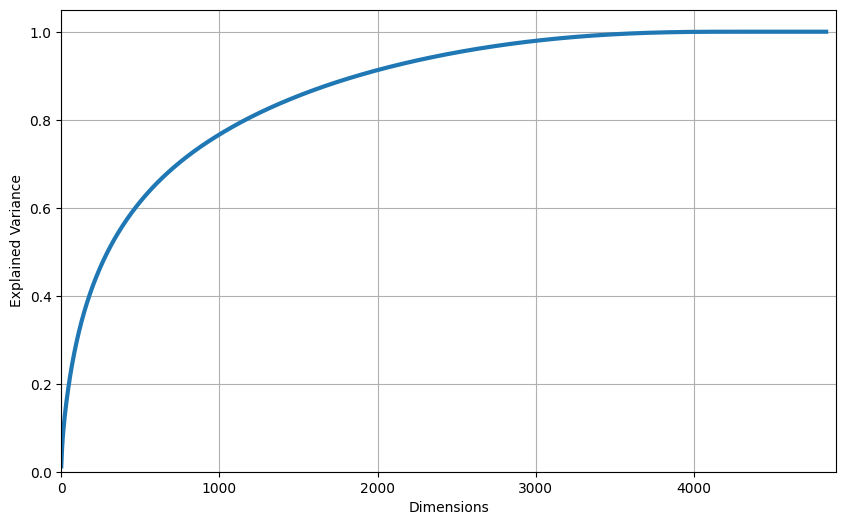

In [113]:
plt.figure(figsize=(10, 6))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 4900, 0, 1.05])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.grid(True)
plt.show()

In [115]:
pca = PCA(n_components=0.9)
X_reduced = pca.fit_transform(tfidf_docs)
pca.n_components_

1874